# Deep Learning Lab Week 6
## Exercise 1
## Pratinav Seth
## 200968216

WEEK 6:

EXERCISE 1:

https://keras.io/examples/structured_data/wide_deep_cross_networks/

Use the Covertype dataset from the UCI Machine Learning Repository. The task is to predict forest cover type from cartographic variables.

## Setup

In [18]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}")
raw_data.head()

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


Create two representations of the input features: sparse and dense:
1. In the sparse representation, the categorical features are encoded with one-hot encoding using the CategoryEncoding layer. This representation can be useful for the model to memorize particular feature values to make certain predictions.
2. In the dense representation, the categorical features are encoded with low-dimensional embeddings using the Embedding layer. This representation helps the model to generalize well to unseen feature combinations.

In [20]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1)
wilderness_area = raw_data.loc[:, 10:13].apply(lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat([raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],axis=1,ignore_index=True,)
data.columns = CSV_HEADER
data["Cover_Type"] = data["Cover_Type"] - 1
print(f"Dataset shape: {data.shape}")
data.head().T

Dataset shape: (581012, 13)


,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


Split the data into training (85%) and validation (15%) sets.

In [21]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 493560
Test split size: 87452


In [22]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [23]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [24]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()


In [25]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


In [26]:

def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


In [27]:

from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features


Model 1 :
Create a multi-layer feed-forward network, where the categorical features are one-hot
encoded.
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50
hidden_units = [32, 32]

In [28]:

def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


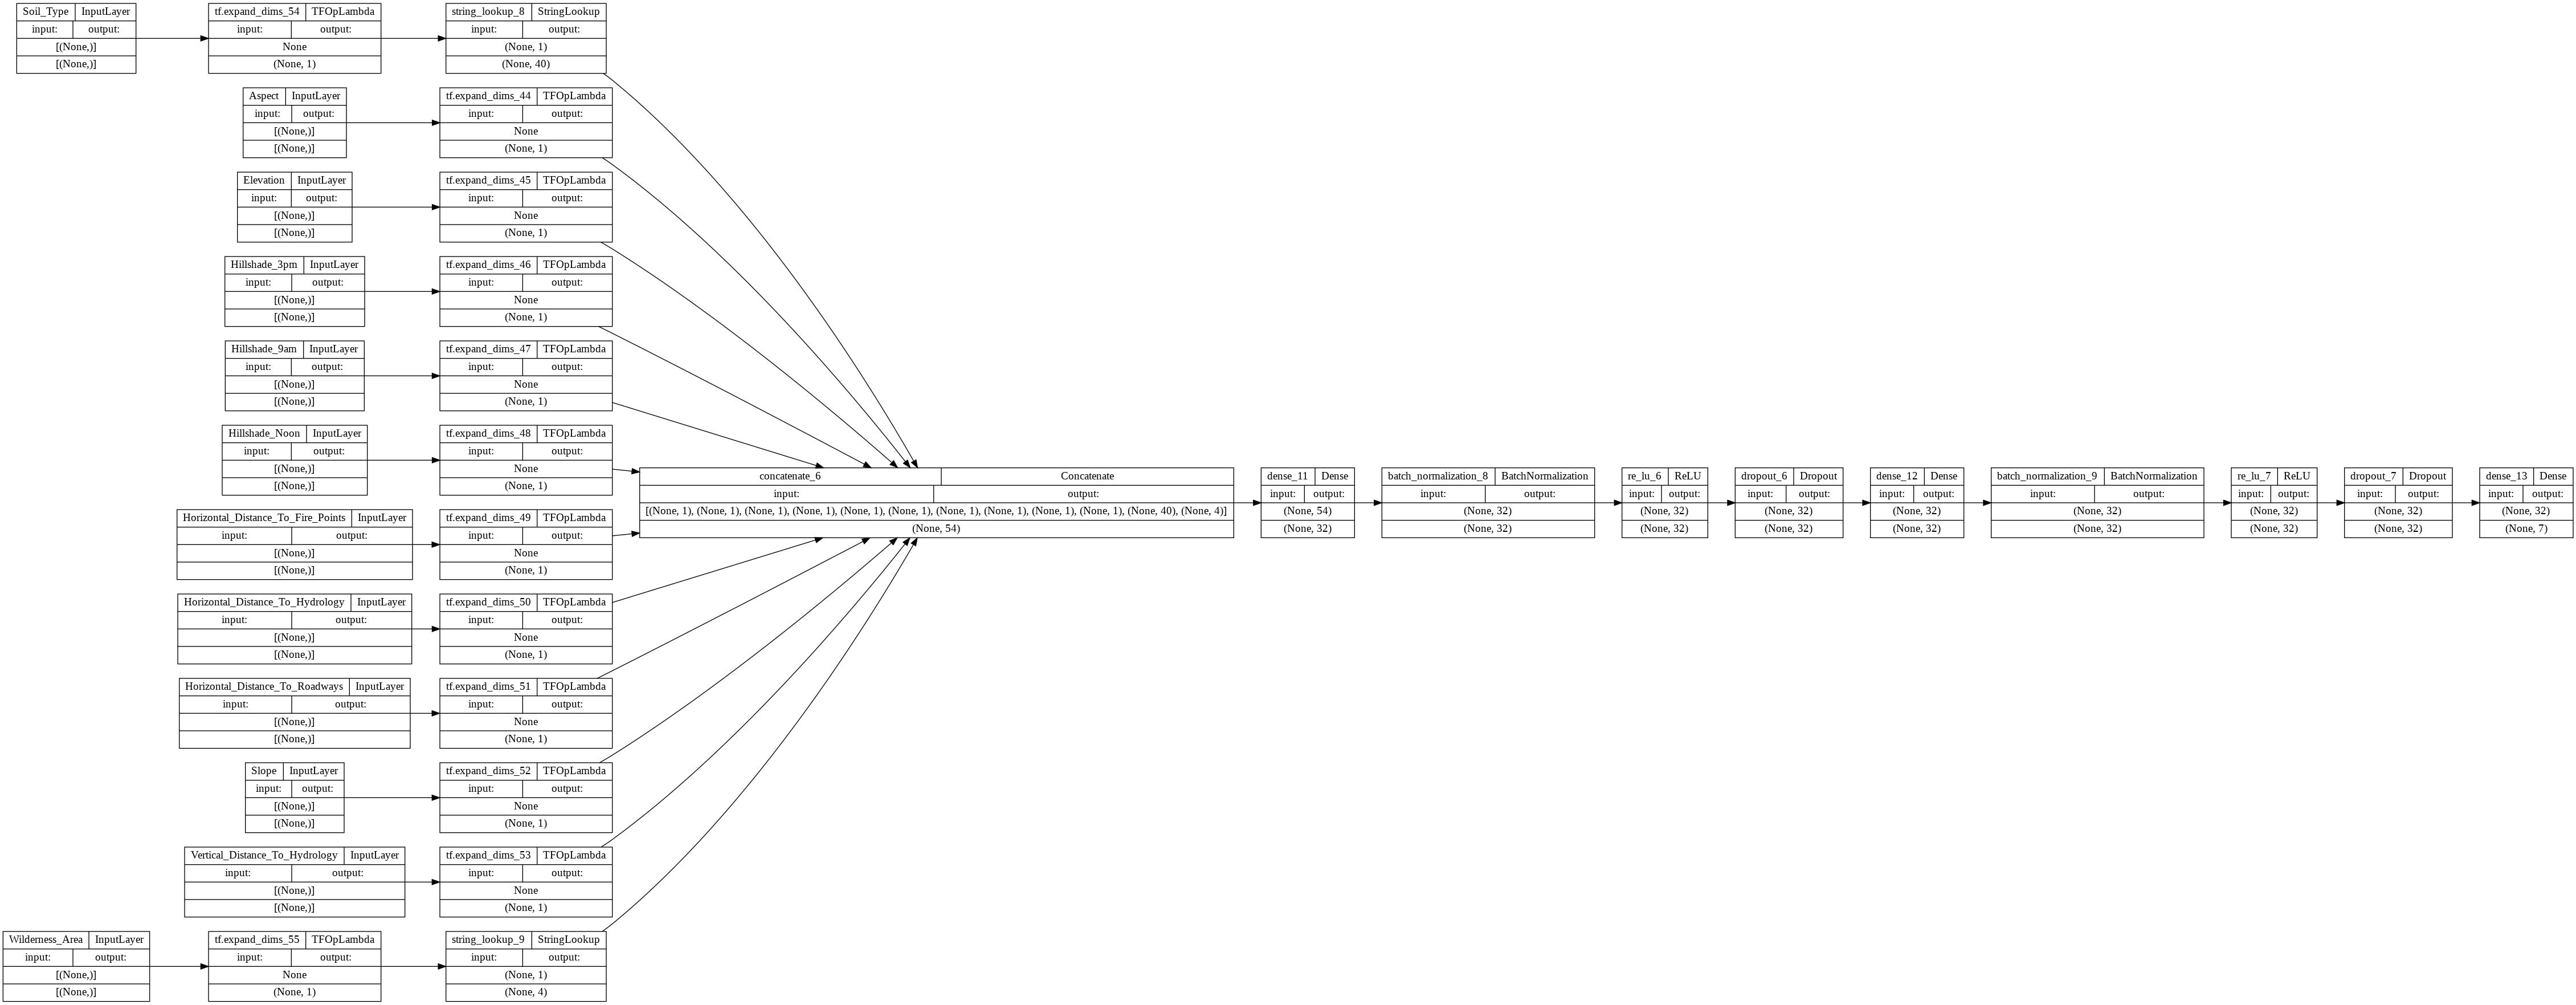

In [29]:
baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [30]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 14s 7ms/step - loss: 0.7513 - sparse_categorical_accuracy: 0.6894
Epoch 2/50
1863/1863 [==============================] - 11s 6ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.7183
Epoch 3/50
1863/1863 [==============================] - 10s 5ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.7278
Epoch 4/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.6154 - sparse_categorical_accuracy: 0.7351
Epoch 5/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.6033 - sparse_categorical_accuracy: 0.7410
Epoch 6/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.5954 - sparse_categorical_accuracy: 0.7446
Epoch 7/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.5890 - sparse_categorical_accuracy: 0.7483
Epoch 8/50
1863/1863 [==============================] - 9s 5ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.7500
E

Model 2:
Create a Wide & Deep model where the wide part of the model a linear model, while the
deep part of the model is a multi-layer feed-forward network. Use the sparse
representation of the input features in the wide part of the model and the dense
representation of the input features for the deep part of the model.

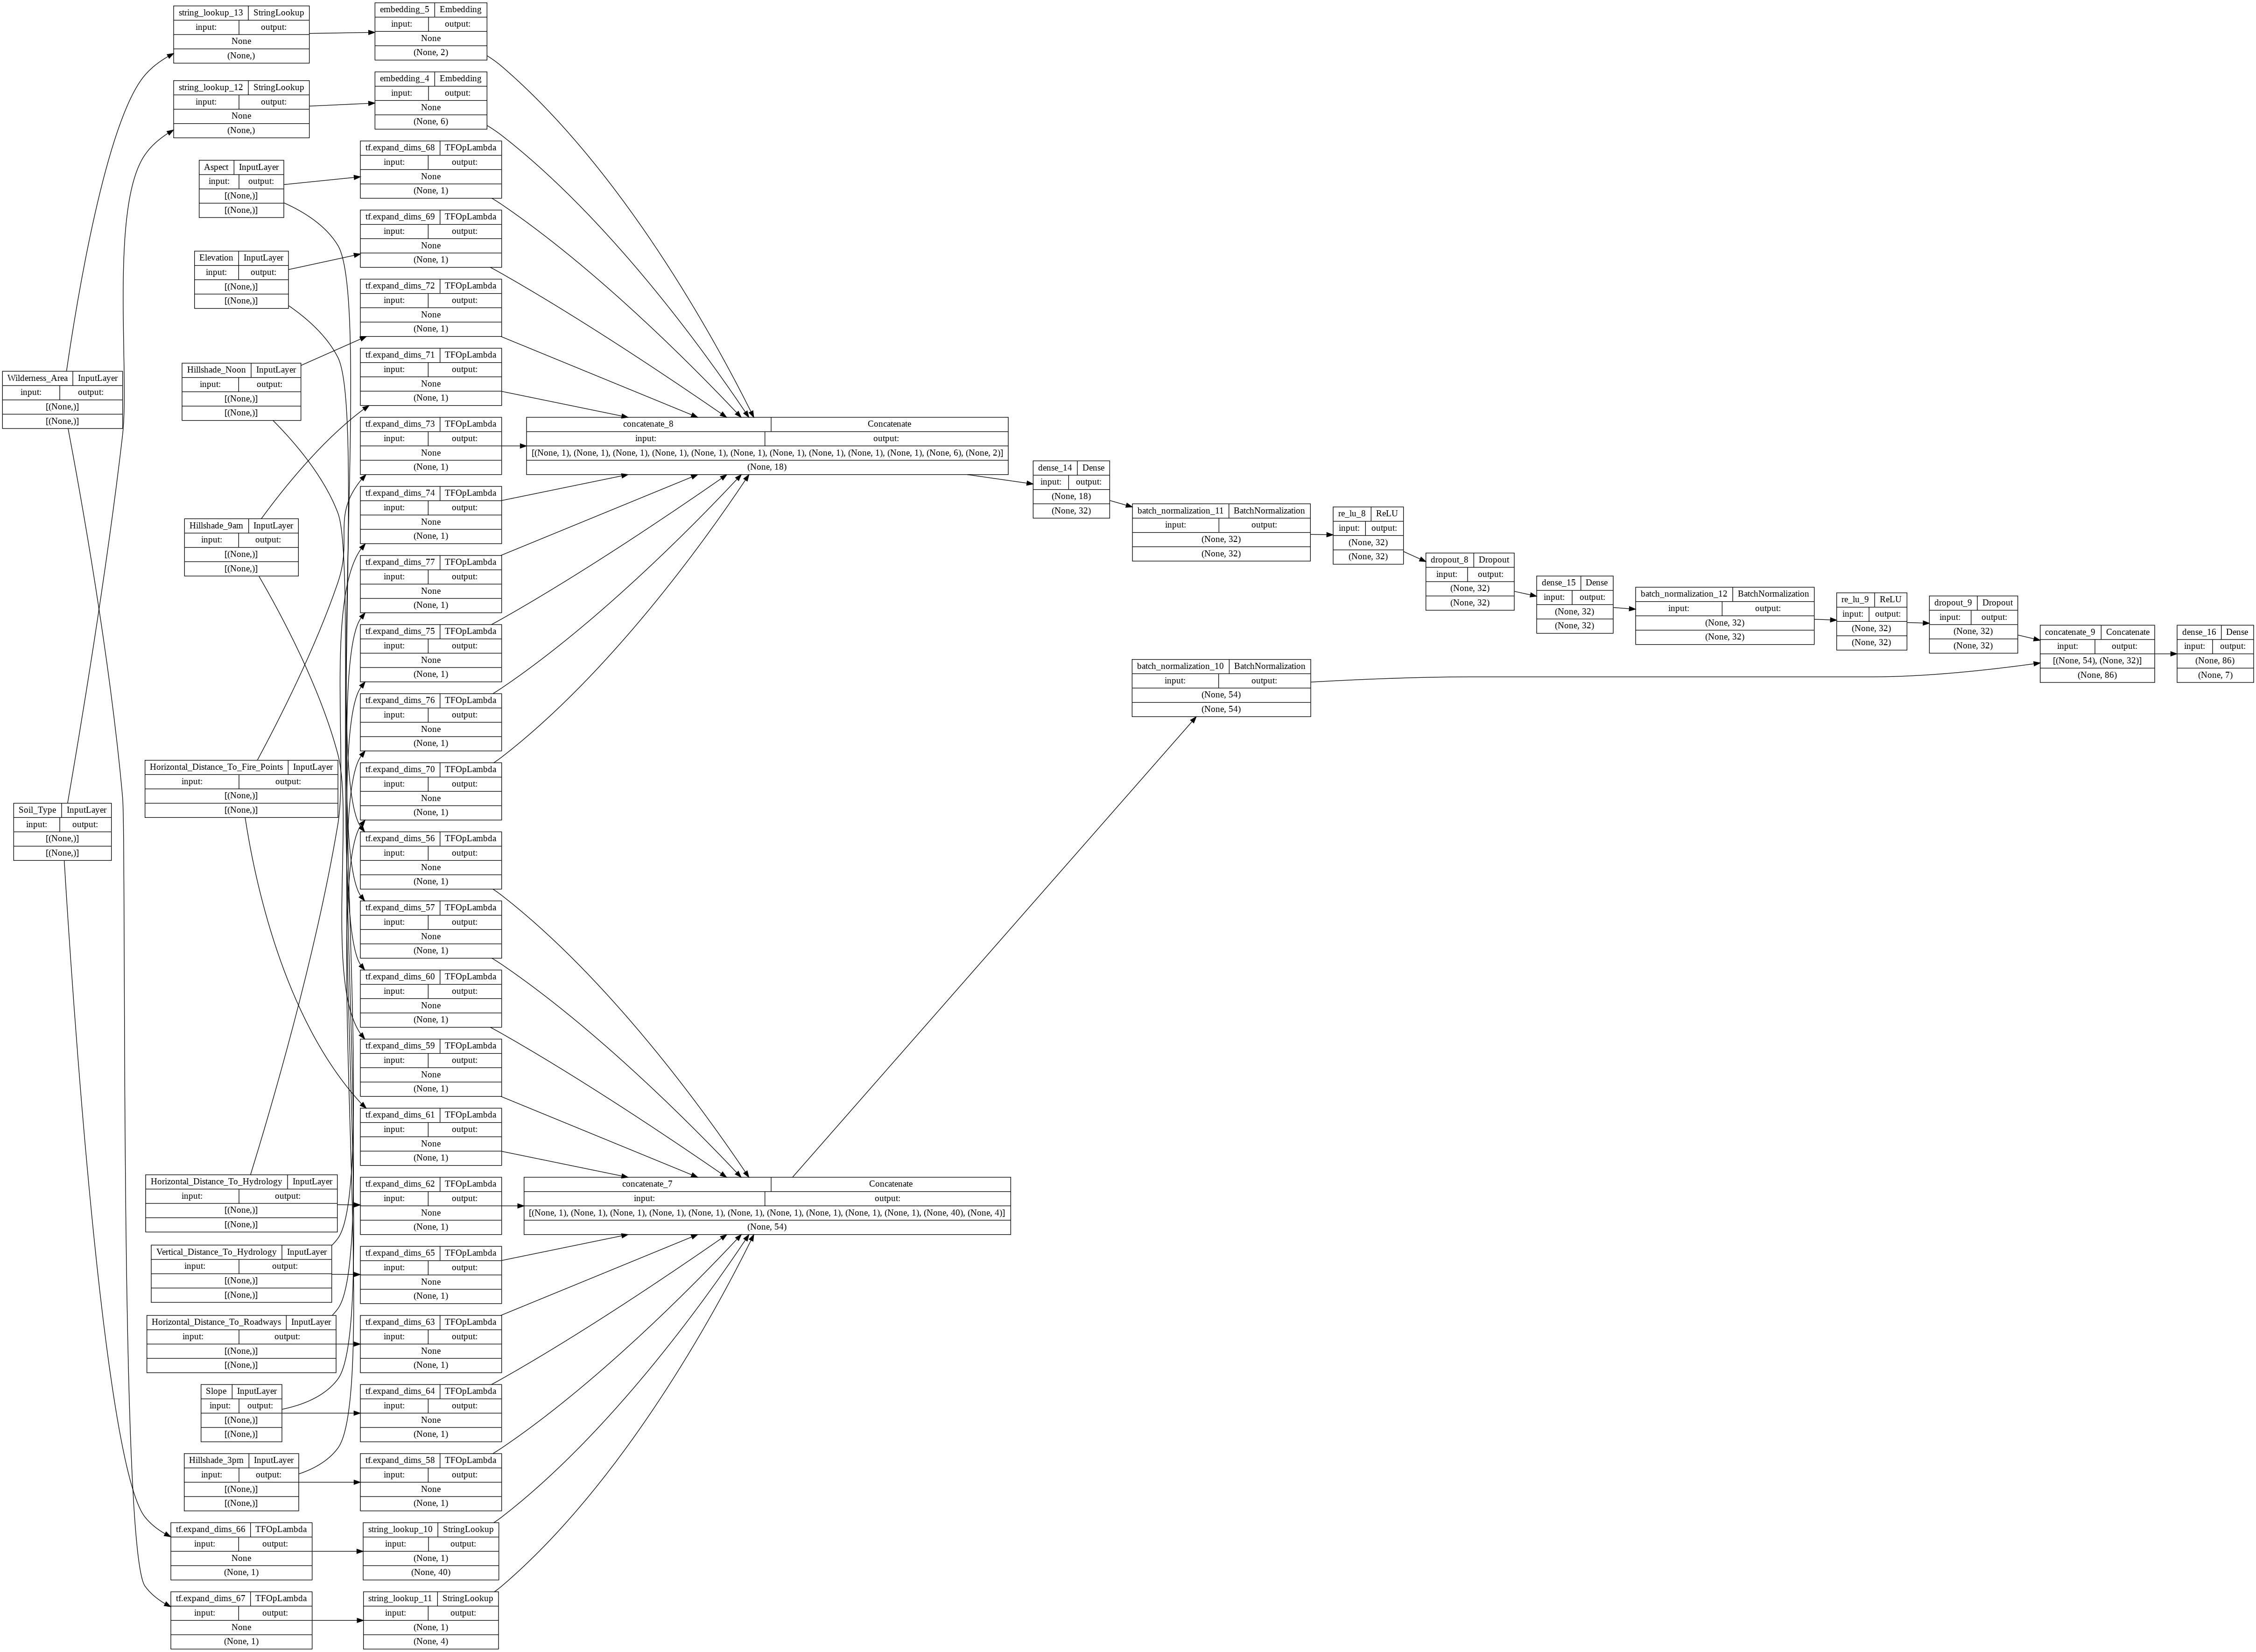

In [31]:

def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [32]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 17s 8ms/step - loss: 0.7108 - sparse_categorical_accuracy: 0.7034
Epoch 2/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.6056 - sparse_categorical_accuracy: 0.7377
Epoch 3/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5877 - sparse_categorical_accuracy: 0.7451
Epoch 4/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5751 - sparse_categorical_accuracy: 0.7511
Epoch 5/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5662 - sparse_categorical_accuracy: 0.7554
Epoch 6/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5596 - sparse_categorical_accuracy: 0.7585
Epoch 7/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5544 - sparse_categorical_accuracy: 0.7613
Epoch 8/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5492 - sparse_categorical_accuracy: 0.7

Model 3:
Create a Deep & Cross model. The deep part of this model is the same as the deep part
created in the previous experiment. The key idea of the cross part is to apply explicit
feature crossing in an efficient way, where the degree of cross features grows with layer
depth.


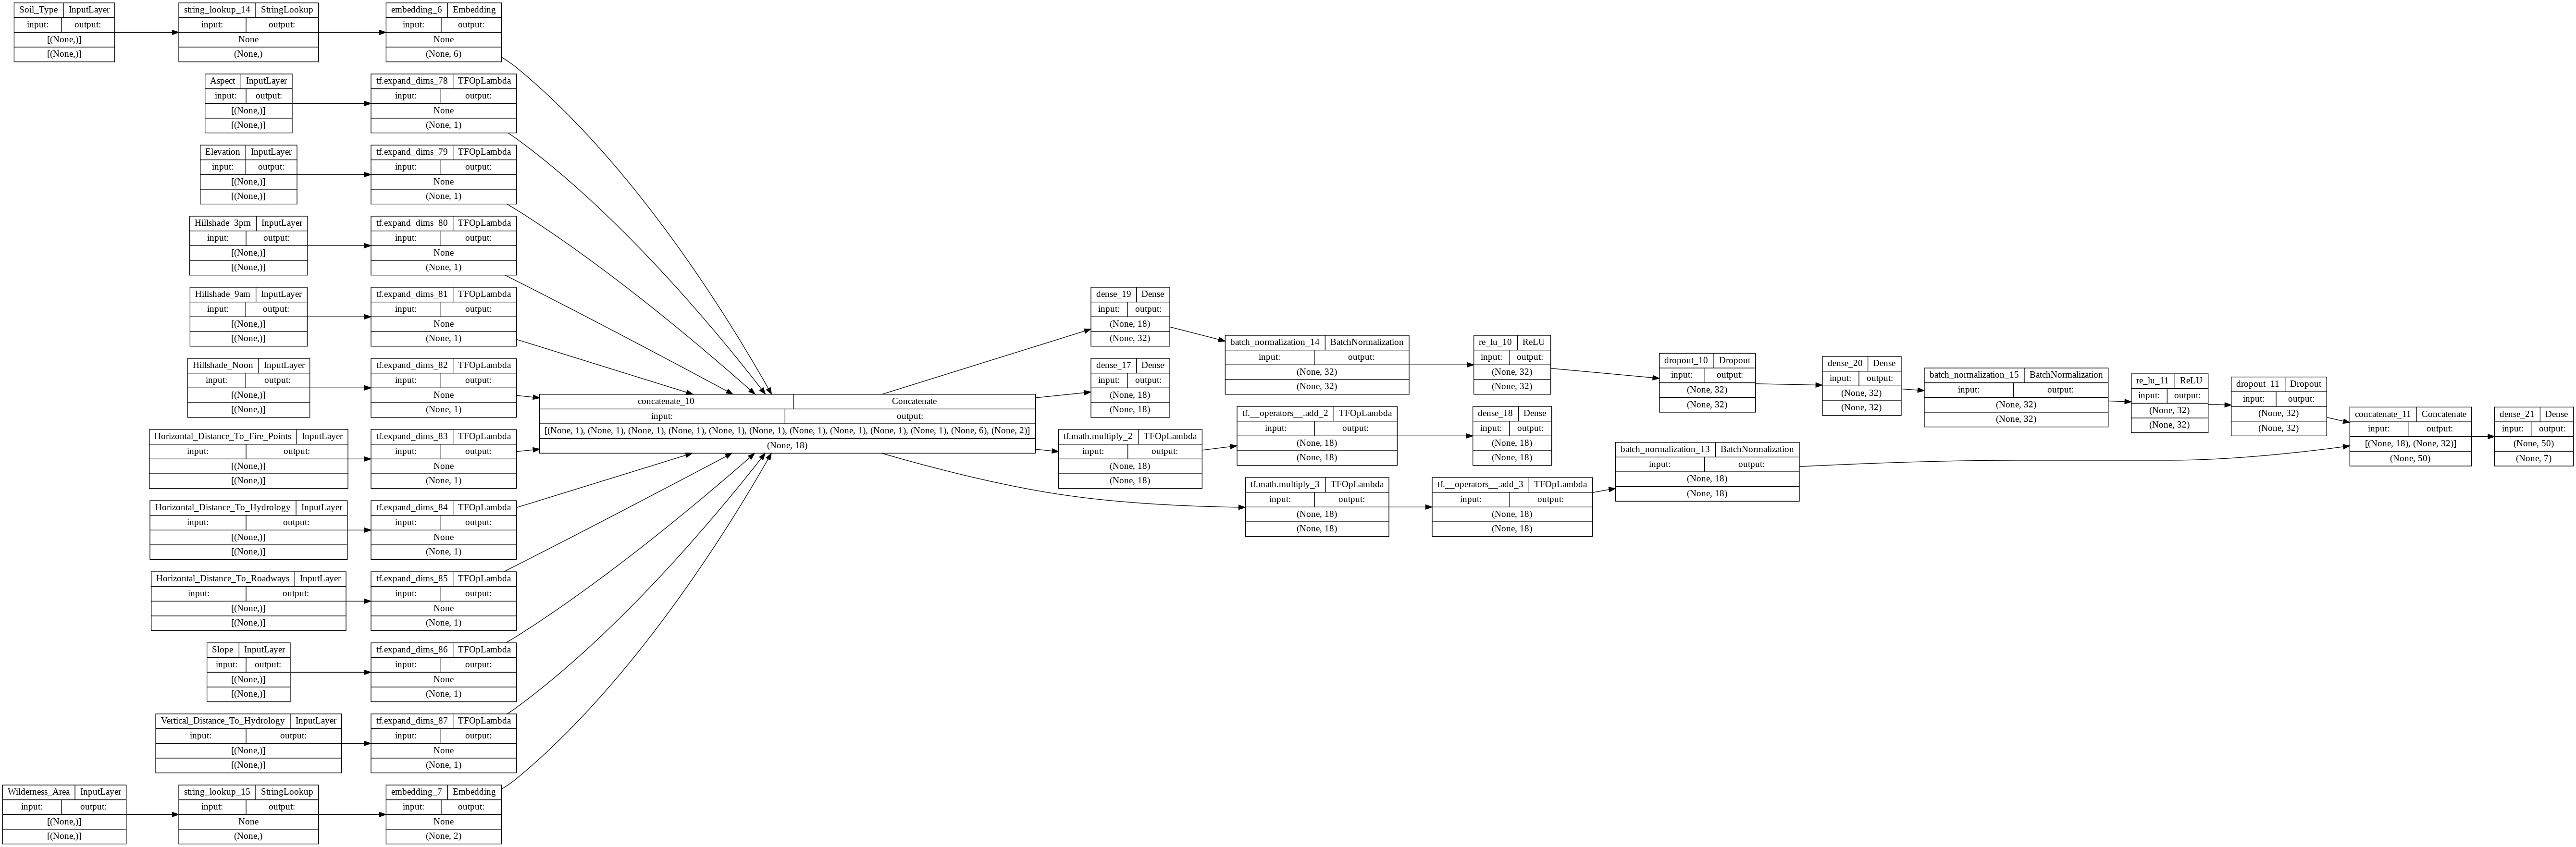

In [33]:

def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [ ]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1863/1863 [==============================] - 17s 8ms/step - loss: 0.6897 - sparse_categorical_accuracy: 0.7111
Epoch 2/50
1863/1863 [==============================] - 15s 8ms/step - loss: 0.5926 - sparse_categorical_accuracy: 0.7442
Epoch 3/50
1863/1863 [==============================] - 13s 7ms/step - loss: 0.5746 - sparse_categorical_accuracy: 0.7520
Epoch 4/50
1863/1863 [==============================] - 12s 6ms/step - loss: 0.5627 - sparse_categorical_accuracy: 0.7571
Epoch 5/50
1863/1863 [==============================] - 12s 7ms/step - loss: 0.5552 - sparse_categorical_accuracy: 0.7602
Epoch 6/50
1863/1863 [==============================] - 11s 6ms/step - loss: 0.5483 - sparse_categorical_accuracy: 0.7636
Epoch 7/50
1863/1863 [==============================] - 11s 6ms/step - loss: 0.5438 - sparse_categorical_accuracy: 0.7656
Epoch 8/50
1863/1863 [==============================] - 11s 6ms/step - loss: 0.5398 - sparse_categorical_accuracy: 0.7

Compare the loss and accuracy of the three models.

We find that Model 1 has a test accuracy of 75.2%, Model 2 has a test accuracy of 80.43% and Model 3 has a test accuracy of 80.73%. 

However when comparing the training loss and accuracies we find that model 1 has acc 77.49%, model 2 has accuracy of 78.85% and 3 have similar acc of 79.26%
For training loss Model 1 - 0.5281, Model 2 - 0.4969 and Model 3 - 0.4827 .

as such based on the 3 metrics we can conclude that model 2 and 3 have comparable performances while model 1 lags far behind either of them